## Optimization of the casino slot floor using linear mixed integer programming
####         Hui Yang, Rank Data Science group
### Business challenge
In a challenging market, how can we increase slots revenue?
Give the current licensing restrictions, there are a number of scientific approaches to optimise current layouts of slot machines:
- Optimising the mix of platform types through mixed integer programming.
<div>
<img src="lp.png" width="500"/>
</div>

### Protocol 
#### Section 1 Data Extraction (pandas)
For each casino we:
- Establish a shared time period (e.g. 90 days) for all machines within a club where there has been no movement or replacement. 
- Calculate the average Coin-in for each machines in the time period.
- Split all the machines into categories by PlatformType.
- For each category, count the number of slots and average Coin-in.

#### Section 2 Linear mixed integer programming (R ompr package)
- Apply the linear mixed integer programming model to obtain the optimal mix of slot machines (using R)
- Predict the number-of-slots change for each categories that maximises potential revenue increase.

#### section 3 Data visulization (matplotlib.pyplot)
- Analyze and visualize the optimized slot floor 

### Linear mixed integer programming 
$$ Max \sum\limits _{i=1} ^{m} c_i * x_i$$
subject to $$ \sum\limits _{i=1} ^{m} x_i \leq M $$
$$ L_i \leq x_i \leq U_i $$ 
$$ x_i \geq>0 $$ 
$$ x_i \in Z $$
Where m = the number of slot machine category <br>
$x_i$ = the number of machines for category i, i = 1, m <br>
$c_i$= CIPUPD for category i<br>
M = the maximum number of total machines allowed on the floor<br>
$L_i$ = the minimum number of machines of category i<br>
$U_i$= the maximum number of machines of category i<br>

#### Assumption / constrains:
- Average Coin-in ($c_i$) for a given slot in a given casino is fixed
- For a casino, the total number of slots (M) is conserved (remains the same)
- We allow a tolerance of +/-10% of the original number of machines ($L_i$/$U_i$).  This can be tailored to each machine type. 

### Section 1 Data Extraction (pandas)
This python script will 
- Extract data from 'SlotsMetreCombineexport.csv' for mixedSlots_comm.R in Section 2. 
- Generate ("MixSlots_%s.csv",my_casino) files including Number_Machines for each category and their Ave_MeteredCoinIn groupby PlatformType. 

In [1]:
import pandas as pd

In [2]:
# read data
# Parameters: Date_Key, Casino, position, Manufacturer, Platform, MeteredCoinIn 
df = pd.read_csv('SlotsMetreCombineexport.csv') 
print(df.shape)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11,17,18,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(1048575, 42)


,Date_Key,Casino,Region,Area,Bank,GameType,position,Manufacturer,CabinetStyle,Platform,...,MeteredPromoTicketsIn,MeteredPromoTicketsOut,MeteredTicketsIn,MeteredTicketsOut,MeteredTotalIn,MeteredTotalInExcludingPromo,MeteredTotalOutExcludingPromo,DropMetersWinExcludingPromo,TheoreticalRTP,TheoreticalWin
0,21/02/2018,London Barracuda,London,Main Licence,1,Electronic Roulette,6,Inspired,Slant,Sabre (Casino 5),...,0.0,0.0,354.75,1154.75,1324.75,1324.75,1366.75,-42.00,8684.27,240.98
1,21/02/2018,London Gloucester Road,London,Main Licence,1,CTB1,54,Novomatic,Upright,Novoline,...,10.0,10.0,1615.80,3766.57,4575.80,4465.80,3766.77,699.03,7584.86,484.14
2,21/02/2018,Walsall,Midlands & West,Main Licence,1,CTB1,38,Novomatic,Upright,Dominator,...,0.0,0.0,92.41,26.85,332.41,332.41,26.85,305.56,482.22,30.78
3,21/02/2018,Stockton,Yorkshire & North East,Main Licence,1,Electronic Roulette,26,Novomatic,Slant,Unity 2 - Original,...,0.0,0.0,0.00,18.40,65.00,65.00,18.40,46.60,661.25,18.35
4,21/02/2018,Portsmouth,South & East,Main Licence,1,Electronic Roulette,5,Novomatic,Slant,Unity 2 - SL2,...,0.0,0.0,100.00,256.20,575.00,575.00,256.20,318.80,2626.86,72.89


#### 1. Establish a shared time period (e.g. lasted 3 months) for all slot machines within a casino where there has been no movement or replacement.     


In [3]:
# 1.1 spcify a casino and time period shared by all slotes
casinos = ['Luton']
my_casino = casinos[0]
start_date = '2018-02-22' # can be updated 
end_date = '2018-06-04' # can be updated 
num_days = pd.to_datetime(end_date,format='%Y-%m-%d') - pd.to_datetime(start_date,format='%Y-%m-%d')
df.Date_Key = pd.to_datetime(df.Date_Key,format='%d/%m/%Y')
df_my_casino = df[(df['Casino'] == my_casino) &  (df.Date_Key >= start_date ) &  (df.Date_Key <= end_date )  &  (df.GameType == 'CTB1' )]
df_my_casino=df_my_casino[['Date_Key', 'Casino', 'position', 'Manufacturer', 'Platform','PlatformType','MeteredCoinIn','GameType']]
print(df_my_casino.shape)

(6158, 8)


In [4]:
# 1.1 Find any moved machines
# Split all the machines into categories by PlatformType.
# At the same postion, if there are >1 MachineTypes => M1 has been moved
dfPos = df_my_casino.groupby(['Manufacturer', 'Platform', 'position'])['Date_Key'].count().reset_index()
dfPos2  = dfPos.sort_values('position')[['Manufacturer', 'Platform', 'position']].\
groupby('position')[['Manufacturer', 'Platform']].count()
machinePositionCount = dfPos.groupby('position')['Manufacturer'].count().reset_index(name='MachineCount')
movedMachines = machinePositionCount[machinePositionCount.MachineCount>1]
print(movedMachines) # print Position & MachineCount >= 2

    position  MachineCount
37        98             2
38        99             2
56       117             2
57       118             2


In [5]:
# 1.2 Check the longest shared time period, update reset start and end date with moved slots, Save to "df_my_casino2"
if movedMachines.empty:
  df_my_casino2=df_my_casino 
  print(casinos[j],'has no machined moved ')
else:    
  # for each position with moved slot M1 -> M2, list the startdate & enddate
  dfM = df_my_casino.merge(movedMachines, on='position', how='right')
  movedgroup = dfM[['Date_Key', 'position', 'Manufacturer', 'Platform','GameType']].groupby(['position', 'Manufacturer', 'Platform'])#.agg('Date_Key':sort)
  startdate=movedgroup.min()
  enddate = movedgroup.max()
  startdate.rename(columns={'Date_Key':'from'},inplace=True)
  enddate.rename(columns={'Date_Key':'to'},inplace=True)
  moveddates = startdate.merge(enddate,left_index=True, right_index=True) 
  list_startdate=moveddates.reset_index().iloc[:,3]
  list_enddate=moveddates.reset_index().iloc[:,5]
  for i in range(int(len(list_startdate)/2)):
    #For each postion, check whether m1 is earlier than m2, if not, swap
    if list_startdate.iloc[0+2*i]<list_startdate.iloc[1+2*i]:  
      continue
    else:
      temp_start=list_startdate.iloc[0+2*i]
      list_startdate.iloc[0+2*i]=list_startdate.iloc[1+2*i]
      list_startdate.iloc[1+2*i]=temp_start

      temp_end=list_enddate.iloc[0+2*i]
      list_enddate.iloc[0+2*i]=list_enddate.iloc[1+2*i]
      list_enddate.iloc[1+2*i]=temp_end
 #find longest shared time period, m1s or m2s       
  if (list_enddate.iloc[::2].min()-list_startdate.iloc[::2].max()) > (list_enddate.iloc[1::2].min()-list_startdate.iloc[1::2].max()):
    start_date2 = list_startdate.iloc[::2].max()  # m1s longer serice
    end_date2 = list_enddate.iloc[::2].min()
  elif (list_enddate.iloc[1::2].min()-list_startdate.iloc[1::2].max()) > (list_enddate.iloc[::2].min()-list_startdate.iloc[::2].max()):
    start_date2 = list_startdate.iloc[1::2].max()  #m2s longer serice
    end_date2 = list_enddate.iloc[1::2].min()
  else: 
    start_date2=start_date
    end_date2= end_date
  df_my_casino2 = df_my_casino[(df_my_casino['Casino'] == my_casino) &  (df_my_casino.Date_Key >= start_date2 ) &  (df_my_casino.Date_Key <= end_date2 )  &  (df_my_casino.GameType == 'CTB1' )]
print("Machine 1 changed date\n",list_startdate.iloc[1::2],"\n")
print("M1s service days:\n",list_enddate.iloc[::2]-list_startdate.iloc[::2],"\n")
print("M2s service days:\n",list_enddate.iloc[1::2]-list_startdate.iloc[1::2])
print( 'Summary: The longest shared time period is', end_date2-start_date2, 'from', start_date2, 'to', end_date2, )#'shared time period'


Machine 1 changed date
 1   2018-05-03
3   2018-05-03
5   2018-05-03
7   2018-05-03
Name: from, dtype: datetime64[ns] 

M1s service days:
 0   69 days
2   69 days
4   69 days
6   69 days
dtype: timedelta64[ns] 

M2s service days:
 1   32 days
3   32 days
5   32 days
7   32 days
dtype: timedelta64[ns]
Summary: The longest shared time period is 69 days 00:00:00 from 2018-02-22 00:00:00 to 2018-05-02 00:00:00


#### 2. Calculate the average Coin-in for each machines in the time period, write new output files

In [6]:
## Split all the machines into categories by PlatformType.
# For each category, count the number of slots, caculate the average Coin-in.
CPUPD = df_my_casino2.groupby('position').MeteredCoinIn.mean().reset_index(name = 'Ave_MeteredCoinIn')
AllSlots=CPUPD.merge(df_my_casino2, on='position', how='right')

AllSlots2=AllSlots[['PlatformType','position','Ave_MeteredCoinIn']].drop_duplicates()
AllSlots3=CPUPD.merge(AllSlots2, on=['position','Ave_MeteredCoinIn'], how='right')
df_mixSlot=AllSlots3.groupby(['PlatformType']).agg({ 'position':'count','Ave_MeteredCoinIn':'mean'})\
     .rename(columns={'position':'Number_Machines'}).reset_index()
df_mixSlot.to_csv('MixSlots_%s.csv' % my_casino, index=False)
## Caculate the capbility of the casino and total CoinIn, add them in the last row
MixSlots=df_mixSlot.append({'PlatformType':'Total', 
              'Number_Machines':df_mixSlot.Number_Machines.sum(), 
                 'Ave_MeteredCoinIn':(df_mixSlot['Number_Machines']*df_mixSlot['Ave_MeteredCoinIn']).sum()
             },ignore_index=True)
# print out on the screen, save to *.csv 
print(MixSlots)
print(casinos[0],'Done\n')

   PlatformType  Number_Machines  Ave_MeteredCoinIn
0  Crystal Dual                7        2052.765918
1     Dominator               13        2745.682489
2    FV880 Slot                2        2784.371429
3           G23               11        1086.196202
4     Gaminator                4        2496.943214
5      Novoline                7        3765.987677
6       Riviera                4        1031.650696
7      SL2 Slot                6        1403.803571
8           VIP                6        2561.562422
9         Total               60      131848.620205
Luton Done



### More casinos in one go

In [7]:
casinos = ['Luton', 'London Victoria','London Russell Square','London Piccadilly']
nCasinos = len(casinos)
#For each casino
for j in range(nCasinos):
    print(j,casinos[j])
#    
# 1. Establish a shared time period (e.g. lasted 3 months) for all machines
#         within a club where there has been no movement or replacement.     
# 1.1 - time period 
    my_casino = casinos[j]
    start_date = '2018-02-22' # can be updated 
    end_date = '2018-06-04' # can be updated 
    num_days = pd.to_datetime(end_date,format='%Y-%m-%d') - pd.to_datetime(start_date,format='%Y-%m-%d')
    df.Date_Key = pd.to_datetime(df.Date_Key,format='%d/%m/%Y')
    df_my_casino = df[(df['Casino'] == my_casino) &  (df.Date_Key >= start_date ) &  (df.Date_Key <= end_date )  &  (df.GameType == 'CTB1' )]
    df_my_casino=df_my_casino[['Date_Key', 'Casino', 'position', 'Manufacturer', 'Platform','PlatformType','MeteredCoinIn','GameType']]
# 1.1 -  moved machines    
#    
    dfPos = df_my_casino.groupby(['Manufacturer', 'Platform', 'position'])['Date_Key'].count().reset_index()
    dfPos2  = dfPos.sort_values('position')[['Manufacturer', 'Platform', 'position']].\
    groupby('position')[['Manufacturer', 'Platform']].count()  #??
    machinePositionCount = dfPos.groupby('position')['Manufacturer'].count().reset_index(name='MachineCount')
    movedMachines = machinePositionCount[machinePositionCount.MachineCount>1]
    #print(movedMachines) # print Position & MachineCount >= 2
    
# 1.2 time: we found the no of moved slot and now to pick
#     the longest shared time period, reset start and end date
    if movedMachines.empty:
      df_my_casino2=df_my_casino 
      print(casinos[j],'has no machined moved ')
    else:    
      dfM = df_my_casino.merge(movedMachines, on='position', how='right')
      movedgroup = dfM[['Date_Key', 'position', 'Manufacturer', 'Platform','GameType']].groupby(['position', 'Manufacturer', 'Platform'])#.agg('Date_Key':sort)
      startdate=movedgroup.min()
      enddate = movedgroup.max()
      startdate.rename(columns={'Date_Key':'from'},inplace=True)
      enddate.rename(columns={'Date_Key':'to'},inplace=True)
      moveddates = startdate.merge(enddate,left_index=True, right_index=True) 
      list_startdate=moveddates.reset_index().iloc[:,3]
      list_enddate=moveddates.reset_index().iloc[:,5]
      for i in range(int(len(list_startdate)/2)):
        if list_startdate.iloc[0+2*i]<list_startdate.iloc[1+2*i]:  #check whether m1 is earlier than m2, if not, swap
        #  print ("")
          continue
        else:
          temp_start=list_startdate.iloc[0+2*i]
          list_startdate.iloc[0+2*i]=list_startdate.iloc[1+2*i]
          list_startdate.iloc[1+2*i]=temp_start
    
          temp_end=list_enddate.iloc[0+2*i]
          list_enddate.iloc[0+2*i]=list_enddate.iloc[1+2*i]
          list_enddate.iloc[1+2*i]=temp_end
     #longest shared time period       
      if (list_enddate.iloc[::2].min()-list_startdate.iloc[::2].max()) > (list_enddate.iloc[1::2].min()-list_startdate.iloc[1::2].max()):
        start_date2 = list_startdate.iloc[::2].max()  #will be refreshed
        end_date2 = list_enddate.iloc[::2].min()
      elif (list_enddate.iloc[1::2].min()-list_startdate.iloc[1::2].max()) > (list_enddate.iloc[::2].min()-list_startdate.iloc[::2].max()):
        start_date2 = list_startdate.iloc[1::2].max()  #will be refreshed
        end_date2 = list_enddate.iloc[1::2].min()
      else: #bug?
        start_date2=start_date
        end_date2= end_date
       
      df_my_casino2 = df_my_casino[(df_my_casino['Casino'] == my_casino) &  (df_my_casino.Date_Key >= start_date2 ) &  (df_my_casino.Date_Key <= end_date2 )  &  (df_my_casino.GameType == 'CTB1' )]
    print( 'The longest shared time period is', end_date2-start_date2, 'from', start_date2, 'to', end_date2, )#'shared time period'

# 2. Calculate the average Coin-in for each machines in the time period.
# 3. Split all the machines into categories by PlatformType.
# 4. For each category, count the number of slots and average Coin-in.
    CPUPD = df_my_casino2.groupby('position').MeteredCoinIn.mean().reset_index(name = 'Ave_MeteredCoinIn')
    AllSlots=CPUPD.merge(df_my_casino2, on='position', how='right')

    AllSlots2=AllSlots[['PlatformType','position','Ave_MeteredCoinIn']].drop_duplicates()
    AllSlots3=CPUPD.merge(AllSlots2, on=['position','Ave_MeteredCoinIn'], how='right')
    df_mixSlot=AllSlots3.groupby(['PlatformType']).agg({ 'position':'count','Ave_MeteredCoinIn':'mean'})\
         .rename(columns={'position':'Number_Machines'}).reset_index()

# 5. save to *.csv separately and print out on the screen
    df_mixSlot.to_csv('MixSlots_%s.csv' % my_casino, index=False)
    MixSlots=df_mixSlot.append({'PlatformType':'Total', 
                  'Number_Machines':df_mixSlot.Number_Machines.sum(),    
                                'Ave_MeteredCoinIn':(df_mixSlot['Number_Machines']*df_mixSlot['Ave_MeteredCoinIn']).sum()
                 },ignore_index=True)        
    print(MixSlots)
    print(j,casinos[j],'test done\n')
#  resutls are printed out  on the screen, saved to *.csv separately for all casinos  

0 Luton
The longest shared time period is 69 days 00:00:00 from 2018-02-22 00:00:00 to 2018-05-02 00:00:00
   PlatformType  Number_Machines  Ave_MeteredCoinIn
0  Crystal Dual                7        2052.765918
1     Dominator               13        2745.682489
2    FV880 Slot                2        2784.371429
3           G23               11        1086.196202
4     Gaminator                4        2496.943214
5      Novoline                7        3765.987677
6       Riviera                4        1031.650696
7      SL2 Slot                6        1403.803571
8           VIP                6        2561.562422
9         Total               60      131848.620205
0 Luton test done

1 London Victoria
The longest shared time period is 46 days 00:00:00 from 2018-02-22 00:00:00 to 2018-04-09 00:00:00
   PlatformType  Number_Machines  Ave_MeteredCoinIn
0  Crystal Dual                4        4936.362234
1     Dominator               15        7035.637234
2           G23              

### Section 2 Linear mixed integer programming (R ompr package)
R script "mixedSlots_comm.R" 
- Read "MixSlots_%s.csv" files including Number_Machines and Ave_MeteredCoinIn groupby 'Platform'.
- write the Opt_Number_Machines and the revenue_increase in the ("MixSlots_%s_opt.csv",my_casino) files.

See you later!

### Section 3 Data visulization (matplotlib.pyplot)
Welome back! Let's analyze and visualize the optimized slot floor  :)

In [8]:
import matplotlib.pyplot as plt
df = pd.read_csv('MixSlots_Luton_opt.csv', encoding='latin')
df =df[:-2] # drop the last 2 rows
#df

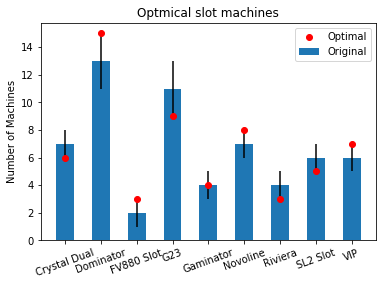

In [9]:
ori=df['Number_Machines']
up=df['upperbounds']
lo=df['lowerbounds']
opt=df['Opt_Number_Machines']
co=df['Ave_MeteredCoinIn']

y=ori
ymin=lo
ymax=up
ytop = ymax-y
ybot = y-ymin

N=len(ori)
x=df['PlatformType']
width =1/2

plt.bar(x, ori, width, yerr=(ybot, ytop),zorder=1,label='Original')
plt.scatter(x, opt,color = 'r',marker = 'o',zorder=2, label='Optimal')
plt.xticks(x, rotation='20')
plt.ylabel('Number of Machines')
plt.title('Optmical slot machines')
plt.legend()
plt.savefig('Luton1.png',bbox_inches='tight',dpi=250)
plt.show()
# The plot helps identify which categories can be added and which can be reduced. 
# To be added: type 1,2,5,8, To keep the same: Gaminator
# The model could produce higher objective functions with looser constraints.

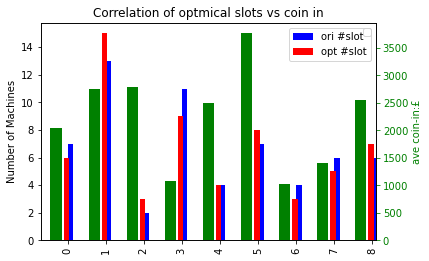

In [10]:
fig = plt.figure() 
ax = fig.add_subplot(111)
#ax2 = fig.add_subplot(111)
ax3 = ax.twinx()
width = 0.3

ori.plot(kind='bar', color='blue', ax=ax, width=width/2, position=0)
plt.legend(['Number of slot machines' ])
opt.plot(kind='bar', color='r', ax=ax, width=width/2, position=0.7)
co.plot(kind='bar', color='g', ax=ax3, width=width, position=1.5)

ax.set_ylabel('Number of Machines')
ax3.set_ylabel('ave coin-in:£')
ax3.yaxis.label.set_color('green')
ax3.tick_params(axis='y', colors='g')
ax.legend(['ori #slot','opt #slot'])
plt.title('Correlation of optmical slots vs coin in')

plt.savefig('Luton_coinin2.png',bbox_inches='tight',dpi=250)
# The plot helps to understand the resutls by adding 
# coin in data (green bars) for each slot catogery.
# Category 1,2,5,8, have relatively high green bar.
# Therefore optimization outcome suggests to add slots with high coin in, 
## to keep the same type 4, and to reduce the rest categories.

### Conclusion
- A solid model to optimize the casino slot floor has been built
- Automate the procedure with python and R
- All sets of optimal mixed slots have been got from Feb-June 2018
- 75% casinos have the revenue increase >5%

### Executive Summary
- The research provides casino operators with a systematic method to improve the performance of the casino slot floor.
- Achieved between 5% and 10% uplift in coin in by optimising the mix of slot machines across the UK.
- Equates to approx. £10,000,000,000 increase in income over a 3-month window.

### Outlook
- Change/add constrains to make the method designated
    - Modify the tolerance of slots in a casino
    - Apply on different categories of the slots, such as gametype 
- Wrap the method as a package/APP
- A paper
- To apply a set of data to a casino in the UK, and to track its revenue change
